### Calculate Threshold from Benchmark Period 1981-2010

[INFO] Processing data\History weather station data\1981.tar.gz ...
[INFO] Processing data\History weather station data\1982.tar.gz ...
[INFO] Processing data\History weather station data\1983.tar.gz ...
[INFO] Processing data\History weather station data\1984.tar.gz ...
[INFO] Processing data\History weather station data\1985.tar.gz ...
[INFO] Processing data\History weather station data\1986.tar.gz ...
[INFO] Processing data\History weather station data\1987.tar.gz ...
[INFO] Processing data\History weather station data\1988.tar.gz ...
[INFO] Processing data\History weather station data\1989.tar.gz ...
[INFO] Processing data\History weather station data\1990.tar.gz ...
[INFO] Processing data\History weather station data\1991.tar.gz ...
[INFO] Processing data\History weather station data\1992.tar.gz ...
[INFO] Processing data\History weather station data\1993.tar.gz ...
[INFO] Processing data\History weather station data\1994.tar.gz ...
[INFO] Processing data\History weather station d

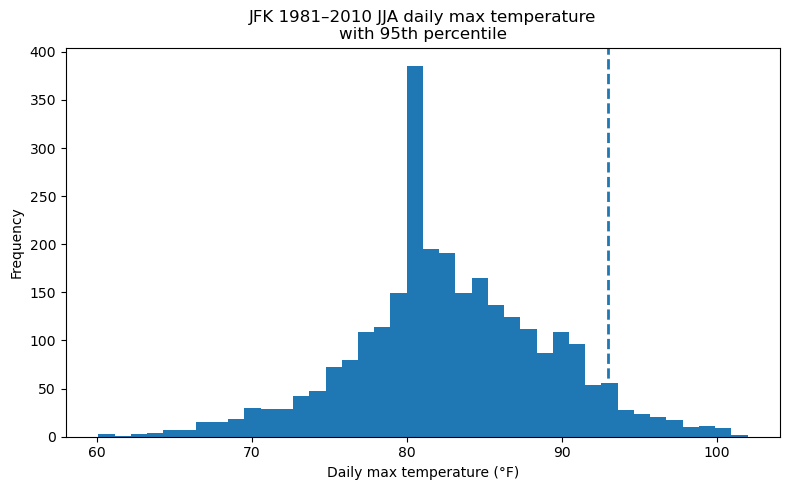

In [4]:
import tarfile
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------- CONFIGURATION -----------------
DATA_DIR = Path("data/History weather station data")               # relative path to data folder
YEARS = range(1981, 2011)             # baseline period: 1981–2010
STATION_FILENAME = "74486094789.csv"  # JFK station file name
# -------------------------------------------------

all_max_temps = []  # store all summer daily max temperatures

for year in YEARS:
    tar_path = DATA_DIR / f"{year}.tar.gz"
    if not tar_path.exists():
        print(f"[WARN] {tar_path} does not exist, skipped.")
        continue

    print(f"[INFO] Processing {tar_path} ...")
    with tarfile.open(tar_path, "r:gz") as tar:
        jfk_member = None
        for member in tar.getmembers():
            # the file may be inside a subfolder, so check only filename ending
            if member.name.endswith(STATION_FILENAME):
                jfk_member = member
                break

        if jfk_member is None:
            print(f"[WARN] {STATION_FILENAME} not found in {tar_path}, skipped.")
            continue

        # extract the CSV file directly from tar.gz
        f = tar.extractfile(jfk_member)
        if f is None:
            print(f"[WARN] Could not extract {STATION_FILENAME} from {tar_path}")
            continue

        # ignore possible header comment lines starting with "#"
        df = pd.read_csv(f, comment="#")

        # unify column names to uppercase
        df.columns = [c.upper() for c in df.columns]

        # DATE column required
        if "DATE" not in df.columns:
            raise ValueError(f"DATE column not found in {STATION_FILENAME}")

        df["DATE"] = pd.to_datetime(df["DATE"])

        # keep only June–August (JJA)
        df_summer = df[df["DATE"].dt.month.isin([6, 7, 8])].copy()

        # find temperature column: MAX or TMAX
        temp_col = None
        if "MAX" in df_summer.columns:
            temp_col = "MAX"
        elif "TMAX" in df_summer.columns:
            temp_col = "TMAX"
        else:
            raise ValueError(f"MAX/TMAX column not found in {STATION_FILENAME}")

        temps = pd.to_numeric(df_summer[temp_col], errors="coerce")

        # replace missing codes like 9999/99999 with NaN then remove them
        temps = temps.replace([9999, 99999, 999.9, 99.9], np.nan)
        temps = temps.dropna()

        all_max_temps.append(temps)

# merge all years into a single Series
if not all_max_temps:
    raise RuntimeError("No valid temperature data found. Check file names and structure.")

all_max_temps = pd.concat(all_max_temps, ignore_index=True)

# NOTE: temperatures are already Fahrenheit → do NOT convert
# (NO scaling applied)

# compute 95th percentile in Fahrenheit
p95_f = np.percentile(all_max_temps, 95)
p90_f = np.percentile(all_max_temps, 90)

print(f"1981–2010 JFK JJA daily max temperature 95th percentile:")
print(f"  {p95_f:.2f} °F")
print(f"  {p90_f:.2f} °F")

# ---------- plot histogram ----------
plt.figure(figsize=(8, 5))
plt.hist(all_max_temps, bins=40)
plt.axvline(p95_f, linestyle="--", linewidth=2)
plt.xlabel("Daily max temperature (°F)")
plt.ylabel("Frequency")
plt.title("JFK 1981–2010 JJA daily max temperature\nwith 95th percentile")
plt.tight_layout()
plt.show()

# Save result to csv
all_max_temps.to_csv("jfk_summer_jja_1981_2010_tmax.csv", index=False, header=["TMAX_C"])

### Filter 2025 summer NYC

In [6]:
import numpy as np
import pandas as pd
from pathlib import Path

# 95th percentile threshold from baseline (1981–2010)
THRESHOLD_F = 91.0

# path to 2025 JFK data
csv_path = Path("data/nyc_two_stations/NYC_JFK_Airport.csv")

# read CSV
df = pd.read_csv(csv_path)

# unify column names to uppercase
df.columns = [c.upper() for c in df.columns]

# parse DATE column
if "DATE" not in df.columns:
    raise ValueError("DATE column not found in NYC_JFK_Airport.csv")

df["DATE"] = pd.to_datetime(df["DATE"])

# keep only year 2025
df_2025 = df[df["DATE"].dt.year == 2025].copy()

# keep only June–August (JJA)
df_jja = df_2025[df_2025["DATE"].dt.month.isin([6, 7, 8])].copy()

# find max temperature column (Fahrenheit)
temp_col = None
if "MAX" in df_jja.columns:
    temp_col = "MAX"
elif "TMAX" in df_jja.columns:
    temp_col = "TMAX"
else:
    raise ValueError("MAX/TMAX column not found in NYC_JFK_Airport.csv")

# clean temperature values
temps = pd.to_numeric(df_jja[temp_col], errors="coerce")
temps = temps.replace([9999, 99999, 999.9, 99.9], np.nan)
df_jja["TMAX_F"] = temps
df_jja = df_jja.dropna(subset=["TMAX_F"])

# classify extreme heat days (>= 95th percentile threshold)
df_jja["EXTREME_HEAT"] = np.where(df_jja["TMAX_F"] >= THRESHOLD_F, "yes", "no")

# ---------- print summary ----------
total_yes = (df_jja["EXTREME_HEAT"] == "yes").sum()
total_no = (df_jja["EXTREME_HEAT"] == "no").sum()

print("JFK 2025 JJA extreme heat classification (threshold = 93°F)")
print(f"  Extreme heat days (yes): {total_yes}")
print(f"  Non-extreme days (no):   {total_no}")

# counts by month
month_label = df_jja["DATE"].dt.month
crosstab = pd.crosstab(month_label, df_jja["EXTREME_HEAT"])

print("\nExtreme heat days by month (JJA 2025):")
print(crosstab)   # rows: month (6,7,8), columns: yes/no

# ---------- save CSV ----------
# keep only JJA, with date, max temp (°F), and extreme heat flag
output = df_jja[["DATE", "TMAX_F", "EXTREME_HEAT"]].copy()
output = output.sort_values("DATE")

output.to_csv("JFK_2025_JJA_extreme_heat_90.csv", index=False)
print("\nSaved JJA 2025 classification to: JFK_2025_JJA_extreme_heat_90.csv")


JFK 2025 JJA extreme heat classification (threshold = 93°F)
  Extreme heat days (yes): 17
  Non-extreme days (no):   71

Extreme heat days by month (JJA 2025):
EXTREME_HEAT  no  yes
DATE                 
6             24    6
7             20   11
8             27    0

Saved JJA 2025 classification to: JFK_2025_JJA_extreme_heat_90.csv
